#### Adaptive Implementation design

In this notebook we provide some drafts on solving a SIR epidemiological model using the addaptive approach discussed in [Adaptive human behavior in epidemiological models](https://www.pnas.org/doi/full/10.1073/pnas.1011250108#:~:text=Adaptive%20behavior%20implies%20disease%20transmission,once%20a%20disease%20has%20emerged.)

This code contains:

1. Solving the classical SIR system with immunity 
2. Finding values of optimal adaptive selection of susceptible contact rate ($C^s$).
3. Comparison between both models

## Classical approach
Here we just program a function that solves the classic ODE system:

$$
\begin{align*}
    &\frac{dS}{dt}= -C(\cdot)\beta SI/N\\
    &\frac{dI}{dt}= C(\cdot)\beta SI/N -\nu I \\
    &\frac{dZ}{dt}=\nu I.
\end{align*}
$$

Depending on the value of the constant $C(\cdot) \in \mathbb{R}_{>0}$.

In [70]:
from scipy.integrate import odeint
from scipy.optimize import fmin
import numpy as np
import time
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d ### Might be useful

### Plotting Utils

def plot_ode_solution(S,I,Z,t,model,figname):
    plt.plot(t,S,label="Susceptible")
    plt.plot(t,I,label="Infected")
    plt.plot(t,Z,label="Recovered (Immune)")
    plt.title(f"Plot of S-I-Z functions ({model})")
    plt.xlabel("Time (t)")
    plt.ylabel("Proportion of total population")
    plt.legend(loc="upper right")
    plt.rcParams["figure.figsize"] = (10,6)
    plt.savefig(f'{figname}.png')
    plt.show()

##### Solve classical SIR model with constant C(.) and parameters

In [3]:
def odes_simple(x, t, c, beta, nu, N):

    # assign each function to a vector element
    S = x[0]
    I = x[1]
    Z = x[2]

    # classical system depending on c, beta, nu and N
    dSdt = -(beta/N)*c*S*I 
    dIdt = (beta/N)*c*S*I - nu*I 
    dZdt = nu*I 

    return [dSdt, dIdt, dZdt]

In [4]:
def solve_classical_SIR(x0,c,beta,nu,t_max,h):
    
    """
    Solve the classical system with initial conditions
    x_0 = [S_0,I_0,Z_0]
    c,beta,nu parameters of the classical ODE's system.
    Solve for t in [0,t_max]
    Create linspace with points seperated by an uniform distance of h
    """
    S0,I0,Z0= x0[0],x0[1],x0[2]
    N=sum(x0)
    
    t = np.linspace(0,t_max,int(t_max/h))
    x = odeint(odes_simple, x0, t, args=(c,beta,nu,N))

    S = x[:,0]
    I = x[:,1]
    Z = x[:,2]
    
    return S,I,Z

#### Example

We solve a classical SIR model with non adaptive contact rate. Parameters are taken from first example of adaptive model article.

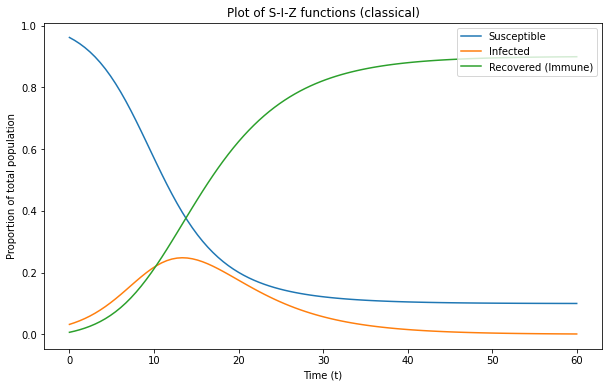

In [76]:
### Initial Conditions
S0 = 30000
I0 = 1000
Z0 = 200
x0 = [S0, I0, Z0]

### Model parameters
c=5
beta=0.0925
nu=0.1823

### Solution x-axis steps
t_max=60
h=60/100
t = np.linspace(0,t_max,int(t_max/h))

### Solve
S_classic,I_classic,Z_classic = solve_classical_SIR(x0,c,beta,nu,t_max,h)

N=sum(x0)
### Plot
plot_ode_solution(S_classic/N,I_classic/N,Z_classic/N,t,"classical",'ex_ante_sol')

We see this exhibits a typical behavior, whith equilibrium found.

## Adaptive approach

The constant $C(\cdot)$ changes through time using a planning window.

The formula for $C(\cdot)$ is given by

$$
C(\cdot)(t) = C^{si}(t) = \frac{N \cdot C^s(t) \cdot C^i(t)}{S(t)\cdot C^s(t) + I(t)\cdot C^i(t) + Z(t) \cdot C^z(t)},
$$

where

- $C^h(t)$ is the optimal number of average contacts made by individuals of type $h \in Y=\{s,i,z\}$ at time $t$.
- $S(t),I(t),Z(t)$ are the number of susceptible, infected and recovered individuals at time $t$.
- $N$ is the entirety of the population.

Thus, in order to find $C(\cdot)(t)$ we need to find the values of the functions of optimal average contacts $C^h(t)$ for $h \in Y$. The idea is that these optimal number of contacts change over time using an utility and value function. For individuals of types $i$ and $z$ the optimal number of average contacts are given by $C^h(t)= 0.5b^h$ where $b^h$ is a given constant. For indiviuals of type $s$ the adaptive algorithm enters the play.

### Computation of optimal $C^s$ at time $t$

For each time there is an optimal $C_t^{s*}$ that has to be introduced into the model to solve it. This approach uses the dynamical programming Bellman equation described in the reference article. We part from the value function at the end of the planning period and move backwards to get the optimal function at the present period.

In [46]:
### Solves the ODE system in an interval 
### We need to implement the computation of C_t^{s*}

def get_Cs_opt(S,I,Z,bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,t):
    
    """
    Select the optimal C_t^s in the interval [0, 0.5b^s] for which we attain the maximum of the 
    value function. For now I'm using the direct implementation from equation (2.2) in the notes.
    We might need to review this and instead use the backwards induction technique.
    
    Attributes:
    - values of S_t,I_t,Z_t at time t.
    - adaptive utility parameters b^z,b^i,b^s,gamma.
    - time window planning info: tau, delta.
    - SIR model parameters: beta, nu.
    - time: t
    """
    
    phi_t = S*0.5*bs + I*0.5*bi + Z*0.5*bz  ### Questions
    
    Pz = 1 - math.exp(-1*nu)  ### Probability of recovery.
    xi = ( (1 - delta**(tau+1) )/(1 - delta) ) - ( (1 - ( delta*(1-Pz) )**(tau+1)  )/( 1 - delta*(1-Pz) ) ) ### Xi function in notes
    vti = ((0.25* (bz)**2 )**gamma - az)*xi ### Value of V_{t+1}(i) for t inside interval [t_0,t_0+tau-1)
     
    ### Probability that an s-type individual becomes infected at time t.
    ### Depends on selection of C_s^t
    
    def P_it(C_st):
        P_it = 1 - math.exp(-1*(0.5*beta*bi*I*C_st)/phi_t)
        return P_it
    
    """
    Now we employ the backwards induction method to compute C_t^s.
    - The idea is that the individual will become infected at time tau.
    - We start with time t+tau and move backwards to time t
    """
    
    def vs1(C_st, vti):
        expr0 = 0.5*beta*bi*I*math.exp(-1*(0.5*beta*bi*I*C_st)/phi_t)
        expr1 = (gamma*(bs*C_st - C_st**2)**(gamma-1) + bs -2*C_st) / expr0
        expr2 = (1 - P_it(C_st))*expr1 + vti
        return (bs*C_st - C_st**2)**gamma - as1 - delta*expr2
    
    #print(f"for t={t} we compute C^s_opt")
    #start=time.time()
    C_st_array = np.linspace(0,0.5*bs,1000)
    C_st_args = [0]*(tau+1)
    Vs1s=[0]*(tau+1) ### length is tau+1 [goes from 0 to tau]
    Vi1s=[vti]*(tau - 1) + [(0.25* (bi)**2 )**gamma - ai] + [0]  ###length is tau+1
    
    ### t+tau
    C_st_tau_step = [vs1(C_st, vti = Vi1s[tau] ) for C_st in C_st_array]
    Vs1s[tau] = max(C_st_tau_step) ### This is V_{t_0+tau + 1}
    C_st_args[tau] = C_st_array[np.argmax(C_st_tau_step)]
    
    ### Go over all the other steps (backwards):
    for j in range(1,tau+1):
        
        ### Get V_{t_0 + tau - j + 1}(i)
        v_i_tau_j_1=Vi1s[tau-j+1]
        ### Get V_{t_0 + tau - j + 1}(s)
        v_s_tau_j_1=Vs1s[tau-j+1]
        
        ### Use formula (6) of article to find V_{t_0+ tau -j}
        val_func_values = [ (bs*C_st - C_st**2)**gamma - as1 + delta*((1 - P_it(C_st))*v_s_tau_j_1 + P_it(C_st)*v_i_tau_j_1) for C_st in C_st_array]
        Vs1s[tau-j] = max(val_func_values)
        C_st_args[tau-j] = C_st_array[np.argmax(val_func_values)]
    
    Cs_opt=C_st_args[0]
    #end=time.time()
    #print(f"for t={t} computing C^s_opt took {end-start} seconds")
    
    return Cs_opt

In [47]:
def odes_adaptive(x,t,bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,N, ex="post"):

    # assign each function to a vector element
    S = x[0]
    I = x[1]
    Z = x[2]
    
    # To create the ex post and ex ante models described in the article.
    if ex=="post":
        Cs_opt = get_Cs_opt(S,I,Z,bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,t)
    else:
        Cs_opt= 0.5*bs
    
    # adaptive system depending on beta, nu and N
    dSdt = -(beta/N)*(Cs_opt*0.5*bi*N/(S*Cs_opt + I*0.5*bi+Z*0.5*bz) )*S*I 
    dIdt = (beta/N)*(Cs_opt*0.5*bi*N/(S*Cs_opt + I*0.5*bi+Z*0.5*bz) )*S*I - nu*I 
    dZdt = nu*I 

    return [dSdt, dIdt, dZdt]

In [48]:
def solve_adaptive_SIR(x0,bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,t_max,h,ex):
    
    """
    Solve the classical system with initial conditions
    x_0 = [S_0,I_0,Z_0]
    c,beta,nu parameters of the classical ODE's system.
    Solve for t in [0,t_max]
    Create linspace with points seperated by an uniform distance of h
    """
    
    S0,I0,Z0= x0[0],x0[1],x0[2]
    N=sum(x0)
    
    t = np.linspace(0,t_max,int(t_max/h))
    x = odeint(odes_adaptive, x0, t, args=(bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,N,ex))

    S = x[:,0]
    I = x[:,1]
    Z = x[:,2]
    
    return S,I,Z

Experiments

In the following experiments, we get the solutions for the following two models:

1. The *ex ante* model, where $C^s=0.5b^s$ is constant. This means that the average number of contacts made by a susceptible individual are constant.
2. The *ex post* model, where $C^s$ is determined by the adaptive algorithm.

Finally we compare these two models with the classical model.

In [49]:
### Initial Conditions
S0 = 30000
I0 = 1000
Z0 = 200
x0 = [S0, I0, Z0]

### Model parameters
beta=0.0925
nu=0.1823

### Adaptive parameters
bi=6.67
bz=10
bs=bz

ai=1.826
az=0 ### By default
as1=0 ### By default
gamma=0.25
tau=12
delta=0.99986

### Solution x-axis steps
t_max=60
h=60/100
t = np.linspace(0,t_max,int(t_max/h))

### Solve

### Ex ante model ###
S_ante,I_ante,Z_ante = solve_adaptive_SIR(x0, bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,t_max,h,ex="ante")

### Ex post model ###
start=time.time()
S_post,I_post,Z_post = solve_adaptive_SIR(x0, bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,t_max,h,ex="post")
end=time.time()
print(f"Adaptive solution took: {(end - start)/60} minutes") ### Because of the adaptive behavior, this takes some time.

C:\Users\jimmy\AppData\Local\Temp/ipykernel_2372/2228144800.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  expr1 = (gamma*(bs*C_st - C_st**2)**(gamma-1) + bs -2*C_st) / expr0


Adaptive solution took: 29.23704414367676 minutes


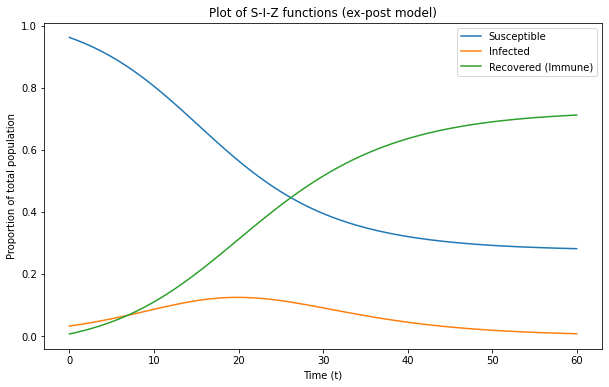

In [75]:
### Plot of x ante solution
N=sum(x0)
plot_ode_solution(S_ante/N,I_ante/N,Z_ante/N,t,"ex-post model",'ex_post_sol')

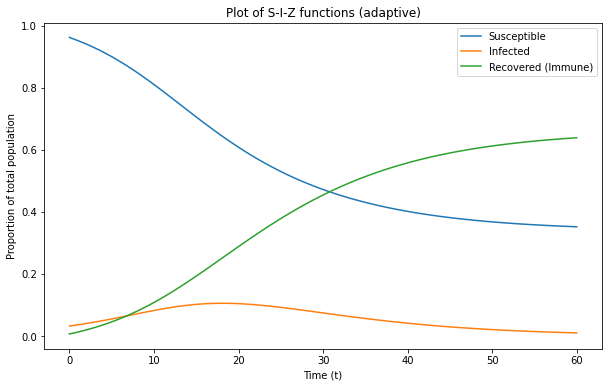

In [74]:
### Plot of x ante solution
plot_ode_solution(S_post/N,I_post/N,Z_post/N,t,"adaptive",'adaptive_sol')

### Review and Comparison

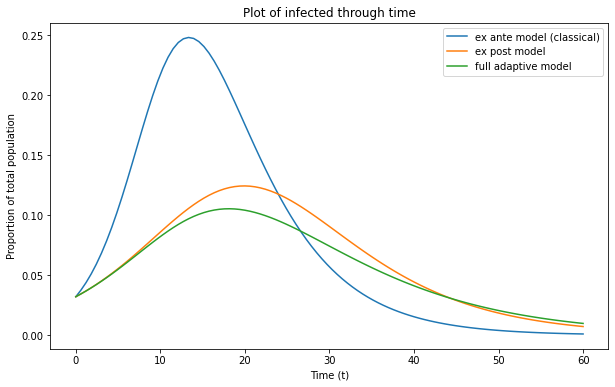

In [77]:
plt.plot(t,I_classic/N,label="ex ante model (classical)")
plt.plot(t,I_ante/N,label="ex post model")
plt.plot(t,I_post/N,label="full adaptive model")
plt.title(f"Plot of infected through time")
plt.xlabel("Time (t)")
plt.ylabel("Proportion of total population")
plt.legend(loc="upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.savefig('infected_comparison.png')
plt.show()

### Discussion

Discuss results and review